#Transfer Learning with tensorflow part 2: Fine tuning

In [43]:
!nvidia-smi

Tue Jun 29 11:58:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |   4788MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-29 11:58:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-29 11:58:48 (48.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [45]:
# import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some data

In [46]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-06-29 11:58:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   173MB/s    in 0.9s    

2021-06-29 11:58:49 (173 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [47]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [48]:
train_dir = "10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"


In [49]:
import tensorflow as tf
img_size = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=img_size,
                                                                            label_mode="categorical",
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=img_size,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [50]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [51]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [52]:
for images, labels in train_data_10_percent.take(1):
  print(images/255.,labels)

tf.Tensor(
[[[[0.30566227 0.27428973 0.2664466 ]
   [0.34295717 0.31158462 0.30374148]
   [0.34511805 0.31206483 0.30506203]
   ...
   [0.15828303 0.11346526 0.09441799]
   [0.14453772 0.10588235 0.10168062]
   [0.11714668 0.09361726 0.1014604 ]]

  [[0.30914366 0.27777112 0.26992798]
   [0.359984   0.32861146 0.32076833]
   [0.3595038  0.32813126 0.32028812]
   ...
   [0.16492555 0.12010779 0.10106052]
   [0.14425755 0.10560219 0.10140046]
   [0.1264303  0.09113619 0.09821928]]

  [[0.28435376 0.25158063 0.25466186]
   [0.34363744 0.31394556 0.30778313]
   [0.35928372 0.32725087 0.32138854]
   ...
   [0.16872708 0.12390932 0.10654255]
   [0.14587834 0.10666265 0.10274108]
   [0.13307312 0.09777901 0.10170057]]

  ...

  [[0.20642217 0.12214823 0.10196036]
   [0.23255284 0.1417962  0.12358917]
   [0.23407353 0.14193639 0.12426952]
   ...
   [0.40400195 0.12332951 0.02837162]
   [0.41182497 0.12947203 0.03535439]
   [0.40922293 0.12686998 0.03275233]]

  [[0.1984998  0.07499008 0.044637

## Model0 

In [53]:
#1 Create bse model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2 Freeze the base model( so the underling pre-trained patterns aren't updated)
base_model.trainable=False

#3 Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#4 If using ResoNet50V2 you will need to normalize inputs(you dont have to for EffiecientB0)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5 pass the inputs
x = base_model(inputs)
print("shape after passing inputs ",x.shape)

#6 Average pool the outputs of the model(aggregate al the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print("shape after global average pooling 2D ", x.shape)

#7 Create the output activation layers
outputs = tf.keras.layers.Dense(10,activation = "softmax", name="output_layer")(x)

#8 Combne the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9 compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10 Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback("transfer_learning",experiment_name="`0_percent_feature_extraction")])

shape after passing inputs  (None, 7, 7, 1280)
shape after global average pooling 2D  (None, 1280)
Saving TensorBoard log files to: transfer_learning/`0_percent_feature_extraction/20210629-115854
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 12s 289ms/step - loss: 1.9230 - accuracy: 0.4013 - val_loss: 1.3760 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 5s 206ms/step - loss: 1.1583 - accuracy: 0.7347 - val_loss: 0.9124 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 5s 205ms/step - loss: 0.8447 - accuracy: 0.8013 - val_loss: 0.7179 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 5s 199ms/step - loss: 0.6859 - accuracy: 0.8533 - val_loss: 0.6766 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 5s 204ms/step - loss: 0.5953 - accuracy: 0.8520 - val_loss: 0.6163 - val_accuracy: 0.8322


In [54]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.6072 - accuracy: 0.8432


[0.6071814894676208, 0.8432000279426575]

In [55]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_5
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

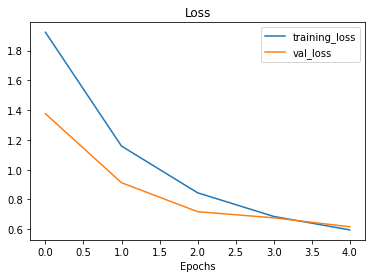

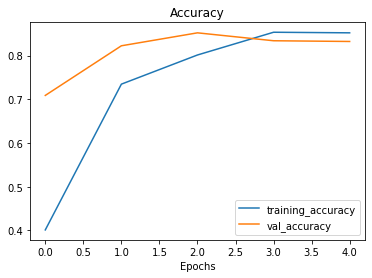

In [56]:
plot_loss_curves(history_0)

##Getting a feature vector from a trained model

In [57]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(input_tensor)

tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)


In [58]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [59]:
# lets replicate the above result mathematically
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

##Running a series of transfer learning experiments

running the experiment by just using 1% of the training data
1. `model_1` taking 1%of data along with data augmentation
2. `model_2` 10% of training data along with data augmentation
3. `model_3` use fine-tuning on 10% of training data with data augmentation
3. `model_3` fine-tuning on 100% training data with data augmentation

In [60]:
#download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-06-29 11:59:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   227MB/s    in 0.6s    

2021-06-29 11:59:52 (227 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [61]:
#setup data loaders

img_size=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=img_size,
                                                                         batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=img_size,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##adding data augmentation right into the model

* `tf.keras.layers.experimental.preprocessing()`

In [62]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
],name="data_augmentation")

###Visual our data augmentation layer

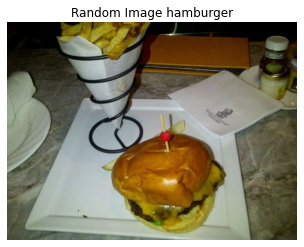

In [63]:
#view a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image
img =mpimg.imread(random_image_path)
plt.title("Random Image "+target_class)
plt.axis(False)
plt.imshow(img)

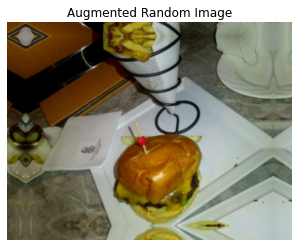

In [64]:
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.title("Augmented Random Image")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img)/255.)

## Model_1: feature extraction transfer learning

In [65]:
from tensorflow.keras import layers
from tensorflow import keras
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210629-115957
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 11s 3s/step - loss: 2.4534 - accuracy: 0.0429 - val_loss: 2.2585 - val_accuracy: 0.1365
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1955 - accuracy: 0.1000 - val_loss: 2.1253 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9745 - accuracy: 0.3429 - val_loss: 2.0291 - val_accuracy: 0.3026
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8153 - accuracy: 0.4714 - val_loss: 1.9300 - val_accuracy: 0.3783
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.6904 - accuracy: 0.4714 - val_loss: 1.8309 - val_accuracy: 0.4293


In [66]:
model_1.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 1.8301 - accuracy: 0.4484


[1.8301304578781128, 0.44839999079704285]

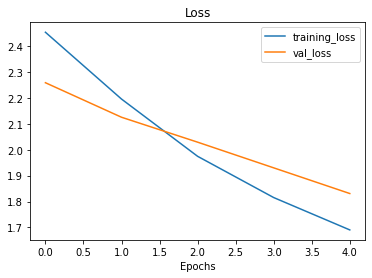

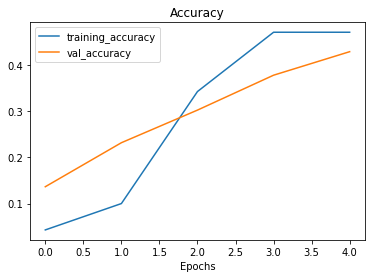

In [67]:
plot_loss_curves(history_1_percent)

##Model 2: same model as Model_1 but training data sa 10%

In [68]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [69]:
img_size=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=img_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=img_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [70]:
# from tensorflow.keras.layers import preprocessing
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2)
],name="data_augmentation")

In [71]:
input_shape=(224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs = layers.Input(shape=input_shape)
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [72]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
24/24 [==============================] - 15s 400ms/step - loss: 1.9503 - accuracy: 0.3653 - val_loss: 1.4878 - val_accuracy: 0.6234
Epoch 2/5
24/24 [==============================] - 10s 387ms/step - loss: 1.3347 - accuracy: 0.6747 - val_loss: 1.0673 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - 8s 316ms/step - loss: 1.0269 - accuracy: 0.7320 - val_loss: 0.8628 - val_accuracy: 0.7714
Epoch 4/5
24/24 [==============================] - 9s 349ms/step - loss: 0.8479 - accuracy: 0.7987 - val_loss: 0.7477 - val_accuracy: 0.7961
Epoch 5/5
24/24 [==============================] - 8s 329ms/step - loss: 0.7847 - accuracy: 0.8067 - val_loss: 0.6688 - val_accuracy: 0.7993


###creating a modelcheckpoint callbacks

In [73]:
#checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#create a model check point call back that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [74]:
initial_epochs=5


In [75]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer learning",
                                                               "10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer learning/10_percent_data_aug/20210629-120128
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 10s 398ms/step - loss: 0.7145 - accuracy: 0.8093 - val_loss: 0.6249 - val_accuracy: 0.8174

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 8s 332ms/step - loss: 0.6609 - accuracy: 0.8320 - val_loss: 0.6166 - val_accuracy: 0.8109

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 8s 324ms/step - loss: 0.6422 - accuracy: 0.8200 - val_loss: 0.6085 - val_accuracy: 0.8076

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 8s 308ms/step - loss: 0.5676 - accuracy: 0.8520 - val_loss: 0.5590 - val_accuracy: 0.8322

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 8s 310ms/step - loss: 0.5567 - accuracy: 0.8560 - val_loss

In [76]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6072 - accuracy: 0.8432


[0.6071814298629761, 0.8432000279426575]

In [77]:
model_1.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 1.8301 - accuracy: 0.4484


[1.830130696296692, 0.44839999079704285]

In [78]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.5505 - accuracy: 0.8408


[0.5505015850067139, 0.8407999873161316]

79/79 [==============================] - 9s 105ms/step - loss: 0.5505 - accuracy: 0.8408


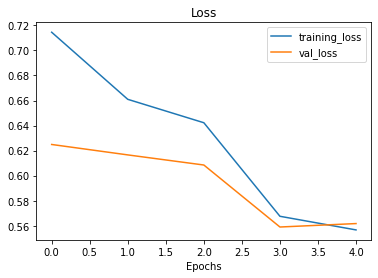

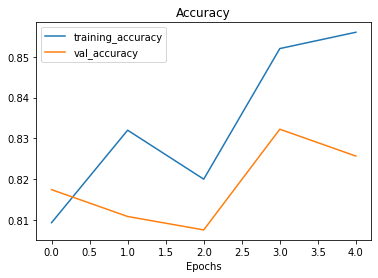

In [79]:
results_10_percent_data_aug = model_2.evaluate(test_data)
plot_loss_curves(history_2)

###Loading in checkpointed weights

In [80]:
#load in saved model
model_2.load_weights(checkpoint_path)

#evaluate model 2 with loades data

In [81]:
loaded_weights_model_result = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.5505 - accuracy: 0.8408


In [82]:
results_10_percent_data_aug,loaded_weights_model_result

([0.5505015850067139, 0.8407999873161316],
 [0.5505015254020691, 0.8407999873161316])

In [83]:
#check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_result))

array([ True,  True])

##Model_3: Fine tuning on 10% of our training data

In [84]:
model_2.layers


In [85]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7feb755a4f90> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7feb755a46d0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7feb71d00950> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7feb71cd6990> True
<tensorflow.python.keras.layers.core.Dense object at 0x7feb71cd75d0> True


In [88]:
for layer in model_2.layers[2].layers:
  print(layer.name,layer.trainable)

input_7 False
rescaling_5 False
normalization_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [89]:
#how many trainable variables in out base model
print(len(model_2.layers[2].trainable_variables))

0


In [91]:
 #to begin fine tuning by making last 10 layers as trainable
 base_model.trainable=True
 for layer in base_model.layers[:-10]:
   layer.trainable=False
#recompile our model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),#when fine tuning lower the loearning rate by 10X
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [93]:
for layer in model_2.layers[2].layers:
  print(layer.name,layer.trainable)

input_7 False
rescaling_5 False
normalization_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [94]:
#now we have unfrozen some of the layers

In [96]:
print(len(model_2.layers[2].trainable_variables))

10


In [97]:
fine_tune_epochs = initial_epochs+5

history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback("transfer learning",
                                                               "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer learning/10_percent_fine_tune_last_10/20210629-122504
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 18s 473ms/step - loss: 0.4764 - accuracy: 0.8693 - val_loss: 0.5078 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 8s 316ms/step - loss: 0.4143 - accuracy: 0.8787 - val_loss: 0.5000 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 8s 327ms/step - loss: 0.3700 - accuracy: 0.8813 - val_loss: 0.4935 - val_accuracy: 0.8306
Epoch 8/10
24/24 [==============================] - 8s 315ms/step - loss: 0.3131 - accuracy: 0.9093 - val_loss: 0.4687 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 8s 306ms/step - loss: 0.2963 - accuracy: 0.9160 - val_loss: 0.4743 - val_accuracy: 0.8487
Epoch 10/10
24/24 [==============================] - 8s 321ms/step - loss: 0.2448 - accuracy: 0.9347 - val_loss: 0.4948 - val_accuracy: 0.8339


In [98]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.4683 - accuracy: 0.8436


In [99]:
results_10_percent_data_aug

[0.5505015850067139, 0.8407999873161316]

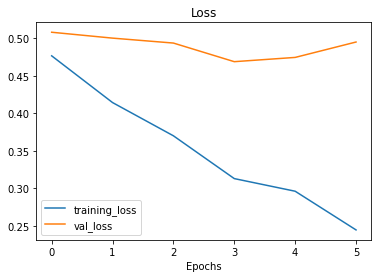

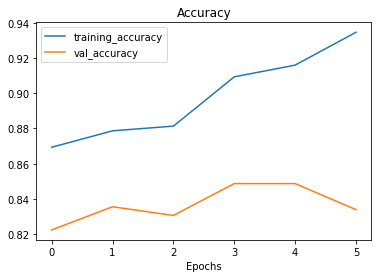

In [100]:
plot_loss_curves(history_3)

In [102]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.809333324432373, 0.8320000171661377, 0.8199999928474426, 0.8519999980926514, 0.8560000061988831, 0.8693333268165588, 0.8786666393280029, 0.8813333511352539, 0.909333348274231, 0.9160000085830688, 0.9346666932106018]


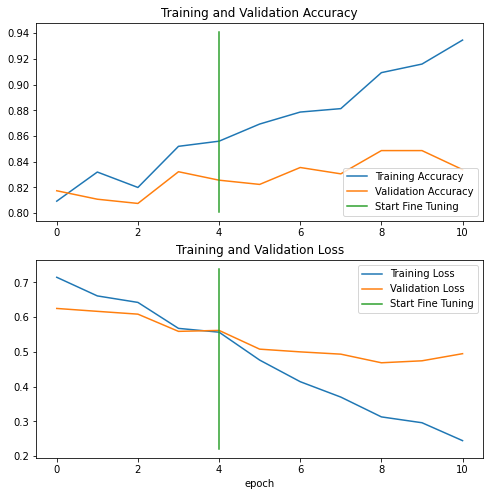

In [104]:
compare_historys(original_history=history_2, 
                 new_history=history_3, 
                 initial_epochs=5)

##Model 4 Fine tuning with 10 unfrozen layer and 100% training data

In [106]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")


--2021-06-29 12:59:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   257MB/s    in 1.9s    

2021-06-29 12:59:56 (257 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [107]:
#setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

In [108]:
#setup data inputs
img_size=(224,224)
train_data_10_class_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                             label_mode="categorical",
                                                                             image_size=img_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                label_mode="categorical",
                                                                image_size=img_size)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [109]:
#load weights from the checkpoin, that way we can fine tune the model
#from where 10 percent model had been fine tuned
model_2.load_weights(checkpoint_path)

model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.5505 - accuracy: 0.8408


[0.5505015850067139, 0.8407999873161316]

In [110]:
results_10_percent_data_aug

[0.5505015850067139, 0.8407999873161316]

Steps
1. trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weight using `ModelCheckpoint` callback
2. Fine tune the same model on the same 10% of the data for further 5 epochs with top 10 layers of the base model unfrozen (model_3)
3. saved the results and training logs each time
4. reloaded the model from step 1 to do the same steps as step 2 except this time weare going to use all of the training data to train out model

In [111]:
model_2.layers[2].trainable

True

In [112]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [116]:
fine_tune_epochs = initial_epochs+5

history_4 = model_2.fit(train_data_10_class_full,
                        epochs=fine_tune_epochs,
                        initial_epoch=history_2.epoch[-1],
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer learning",
                                                               "fine_tune_all_data")])

Saving TensorBoard log files to: transfer learning/fine_tune_all_data/20210629-132522
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 47s 177ms/step - loss: 0.6865 - accuracy: 0.7844 - val_loss: 0.3510 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 52s 218ms/step - loss: 0.5630 - accuracy: 0.8189 - val_loss: 0.2861 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 50s 210ms/step - loss: 0.5023 - accuracy: 0.8415 - val_loss: 0.2811 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 49s 209ms/step - loss: 0.4665 - accuracy: 0.8512 - val_loss: 0.2657 - val_accuracy: 0.9145
Epoch 9/10
235/235 [==============================] - 44s 185ms/step - loss: 0.4199 - accuracy: 0.8641 - val_loss: 0.2727 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 43s 182ms/step - loss: 0.3961 - accuracy: 0.8743 - val_loss: 0.2657 - val_accuracy: 0.9095


In [117]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.2982 - accuracy: 0.9056


[0.29815784096717834, 0.9056000113487244]

6
12
[0.8693333268165588, 0.8786666393280029, 0.8813333511352539, 0.909333348274231, 0.9160000085830688, 0.9346666932106018, 0.7843999862670898, 0.8189333081245422, 0.8414666652679443, 0.8511999845504761, 0.864133358001709, 0.8742666840553284]


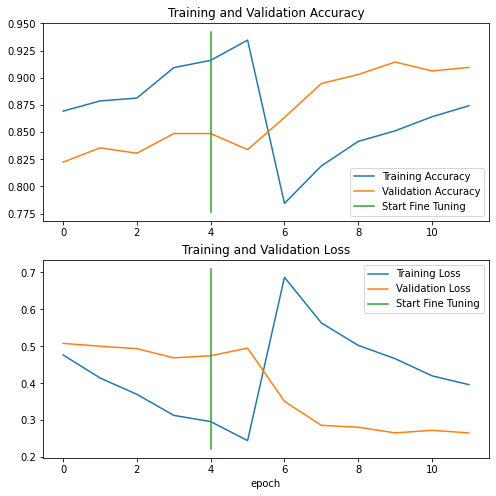

In [119]:
compare_historys(history_3,history_4,5)

##Viewing our experiment data on Tensorboard

In [124]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 classes"\
  --description "l;ol"\
  --one_shot

2021-06-29 13:40:22.101432: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3